# Contamination?
Lately, I've been working a lot on the Kaggle Titanic competition. To pick up good data science practices, I've been taking the time to work through many issues in my machine learning pipeline. One issue that I discovered in the pipeline is  **contamination**. Contamination occurs when you include information about your test set in your training set, and results in an overly-optimistic estimate of your model's score (accuracy, AUC, etc.). It generally arises from processing training and test data **together** before model validation. In this post, I provide two examples of contamination in the pipeline I used for the Kaggle Titanic competition.
  
# Approach for the Kaggle Titanic Competition
Thus far, my broad approach was:  
  
1. Data cleaning
2. Impute values to passenger Age
3. Mean-encode categorical features
4. Use cross validation for feature selection and hyperparameter tuning
  
The first phase required transformation of data that could be done safely on both training and test sets together without contamination. However, the next two phases (missing value imputation and mean encoding) required me to impute values or mean-encode the training set before performing the same transformations **using the training set mappings** on the test set. Finally, I discovered issues with my approach to cross validation in the fourth phase, but I'll address these in a separate post.  
  

In [3]:
# Import modules
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import RFECV, RFE
from sklearn.manifold import Isomap
from sklearn.metrics import accuracy_score, auc, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedKFold, KFold, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, RobustScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
import warnings

# Settings
%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

# Examples on Contamination

## Example 1: Missing Value Imputation of Passenger Age
Approximately 20% of the observations in the feature Age were missing. As such, some kind of imputation was required to make the most of the data.

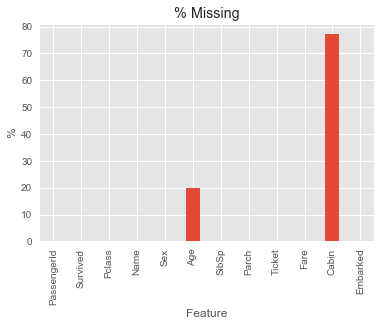

In [13]:
# Import data
df = pd.read_csv('../datasets/train.csv')

# Plot % missing values
(df.isnull().sum(axis = 0) / df.shape[0] * 100).plot.bar()
plt.title('% Missing')
plt.xlabel('Feature')
plt.ylabel('%')
plt.show()

### Approach to Imputation
Having discovered that the distributions of age differed by passengers' titles, I decided to impute missing values using random numbers (with a fixed random seed) drawn from a normal distribution with the following parameters:  
  
1. **Mean:** The median age of people with the same title.
2. **Standard Deviation:** The standard deviation of age of people with the same title.
  

In [15]:
# Extract title
df['title'] = df.Name.str.replace('.*, ', '').str.replace(' .*', '')
df.title[(df.title != 'Mr.') & (df.title != 'Miss.') & (df.title != 'Mrs.') & (df.title != 'Master.')] = 'Other'

# Plot age distributions by title
df.groupby('title').Age.plot.density()
plt.title('Distribution of Age by Density')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

### The Problem
The mistake I made was to perform the imputation on the entire dataset **before** running cross validation for feature selection and hyperparameter tuning. Suppose we have a dataset `X_full` that has been split into a training set `X_train` and a test set `X_test`, both containing the Age feature and other features generated from it. When I imputed missing values on `X_full`, I unknowingly included Age values from `X_test` to inform imputation in `X_train`, because the median and standard deviation of Age in the full dataset were derived from both `X_train` and `X_test`. To see how different they could be, I perform an arbitrary split of the data - first 700 observations for `X_train` and the remainder for `X_test` - and compare the distribution of age of passengers with title "Mrs." and "Other".

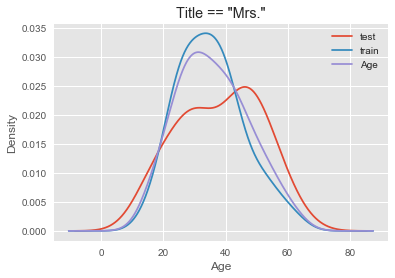

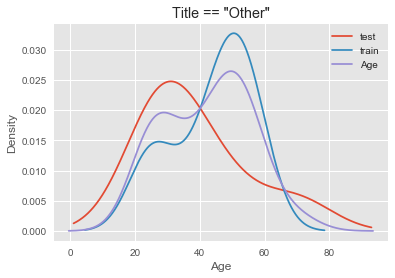

In [83]:
# Attach split identifier
df['Split'] = 'train'
df.loc[700:, 'Split'] = 'test'

# Plot distribution for passengers with the title Mrs.
df[df.title == 'Mrs.'].groupby('Split').Age.plot.density(legend = True)
df[df.title == 'Mrs.'].Age.plot.density(legend = True)
plt.title('Title == "Mrs."')
plt.xlabel('Age')
plt.show()

# Plot distribution for passengers with the title Other
df[df.title == 'Other'].groupby('Split').Age.plot.density(legend = True)
df[df.title == 'Other'].Age.plot.density(legend = True)
plt.title('Title == "Other"')
plt.xlabel('Age')
plt.show()

Using a combined distribution (purple) would compromise the estimates of median and standard deviation from the training set. This leads to inaccuracy because in reality, we would not know the **true** distribution of age of passengers in unseen data. All we have to work with is the train dataset. Hence, imputation on the test set must use the estimates of median and standard deviation from the training set.

## Example 2: Encoding of Features
As part of feature engineering, I mean-encoded several categorical features. Mean encoding is a technique where you replace a category e.g. A, B, and C, with the proportion of "positive" target values it is associated with. In the example below, we have a dataset with 6 training observations, three of which are of category A, and three of which are of category B. 66.67% of category A observations are positive (`target == 1`) and 33.33% are negative (`target == 0`). Thus, we replace all As with 66.67%. We then do the same for all observations of category B. In the test set, the percentages are reversed for category A and B.  

In [95]:
# Create fake data
fake_data = pd.DataFrame(
    [
        {'target': 1, 'cat': 'A', 'split': 'train'}, {'target': 1, 'cat': 'A', 'split': 'train'},
        {'target': 0, 'cat': 'A', 'split': 'train'}, {'target': 1, 'cat': 'B', 'split': 'train'},
        {'target': 0, 'cat': 'B', 'split': 'train'}, {'target': 0, 'cat': 'B', 'split': 'train'},
        {'target': 0, 'cat': 'A', 'split': 'test'}, {'target': 0, 'cat': 'A', 'split': 'test'},
        {'target': 1, 'cat': 'A', 'split': 'test'}, {'target': 1, 'cat': 'B', 'split': 'test'},
        {'target': 1, 'cat': 'B', 'split': 'test'}, {'target': 0, 'cat': 'B', 'split': 'test'}
    ]
)

# Mean encoding
fake_data['cat_full'] = fake_data.cat.map(fake_data.groupby('cat').target.mean())
fake_data['train_only'] = fake_data[fake_data.split == 'train'].cat.map(fake_data[fake_data.split == 'train'].groupby('cat').target.mean())
fake_data['test_only'] = fake_data[fake_data.split == 'test'].cat.map(fake_data[fake_data.split == 'test'].groupby('cat').target.mean())
fake_data['test_mapped'] = fake_data[fake_data.split == 'test'].cat.map(fake_data[fake_data.split == 'train'].groupby('cat').target.mean())

# View
fake_data

,cat,split,target,cat_full,train_only,test_only,test_mapped
0,A,train,1,0.5,0.666667,NaN,NaN
1,A,train,1,0.5,0.666667,NaN,NaN
2,A,train,0,0.5,0.666667,NaN,NaN
3,B,train,1,0.5,0.333333,NaN,NaN
4,B,train,0,0.5,0.333333,NaN,NaN
5,B,train,0,0.5,0.333333,NaN,NaN
6,A,test,0,0.5,NaN,0.333333,0.666667
7,A,test,0,0.5,NaN,0.333333,0.666667
8,A,test,1,0.5,NaN,0.333333,0.666667
9,B,test,1,0.5,NaN,0.666667,0.333333


Had we used the full dataset to perform mean encoding, we would have obtained `cat_full`. That is, we would have (correctly) discovered that the category was not particularly useful for predicting the target. If instead we mapped the training set percentages to the test set, we would have obtained even worse predictions, because the true percentages in the test set were inversed. The model would likely have generated the opposite predictions. The principle here is that data from the test set must not be included in any transformations made on the training set.

# Conclusion
To get unbiased estimates of model accuracy, we must ensure that no information on any feature in the test set is captured in the training set. This does not apply only when scoring the model on a validation set or a training set. It applies also to scoring of the model **during cross validation** (which I'll address in a separate post). To avoid contamination, we need to identify data transformations or feature generation processes that will *might give away test set information*, and handle them separately. These processes should be applied on the **training set only**, and the respective feature mappings should be saved so they can be applied to the test set.